# Optical Digit Recognition with 2D Gaussians 

We assume that each digit from 0 to 9 can be represented by a mixture
of 2D Gaussians.  In our simplified case, each gaussian represents part of a line that may be used to draw the digit in a segment display.  The mean of the
Gaussian is the center of the line segment and the covariance is a diagonal 
matrix with the variance of the line segment along each axis.  

We model the data generating process as follows:
1. Choose a digit from 0 to 9 with equal probability.
2. Choose a noise probability $p_{noise}$ from Unif(0, 0.3).
3. Sample $k$ points where for each point:
    - With probability $p_{noise}$, sample a point from N((0.5, 0.5), (0.5^2, 0.0; 0.0, 0.5^2))
    - Otherwise, sample from the mixture of 2D Gaussians for that digit.

In [2]:
using Gen
using Plots
using Printf
using LinearAlgebra

### Find a good variance.

We first need to find a appropriate variance for the gaussian to represent
a line.  To do so, we use a small variance $\epsilon$ for the thin
dimension of the line and a variance where the 3 sigma confidence interval 
covers the entire segment for the long dimension.  We then visualize this choice.

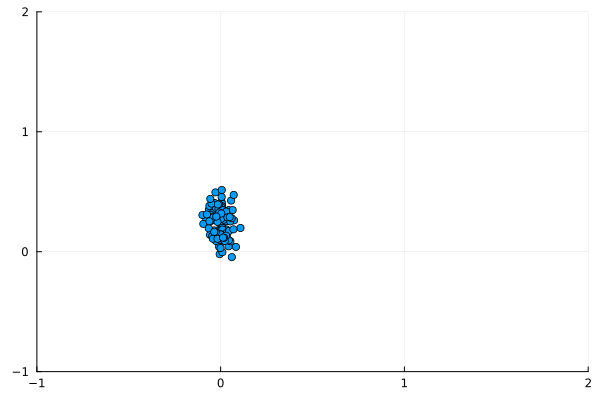

In [3]:
# Try to find a good sigma for vertical and horizontal
@gen function sample_mv_normal(mu, sigma)
    p ~ mvnormal(mu, sigma)
    return p
end


mu = [0.0, 0.25]
sigma = [0.002 0.0; 0.0 (0.25/2)^2]
# should be within 2 sigma
dist = Gen.mvnormal(mu, sigma)
n_samples = 100
xs = zeros(n_samples)
ys = zeros(n_samples)
for i in 1:n_samples
    trace, _ = Gen.generate(sample_mv_normal, (mu, sigma))
    p = Gen.get_retval(trace)
    xs[i] = p[1]
    ys[i] = p[2]
end
Plots.scatter(xs, ys, legend=false, xlim=(-1, 2), ylim=(-1.0, 2.0))

### Define mixtures for digits

In [4]:
mutable struct Digit
    mus::Array{Float64, 2}
    sigmas::Array{Float64, 3}
    weights::Array{Float64, 1}
end

mixture_of_mvnormals = HomogeneousMixture(mvnormal, [1, 2])
# mvunform_0_1 = HomogeneousMixture(uniform, [0, 0])

sigma_v = [0.002 0.0; 0.0 (0.25/2)^2]
sigma_h = [(0.25/2)^2 0.0; 0.0 0.002]

function get_digit(number, noise_prob=0.0)
    if number == 0
        mus = cat(
            [0.25, 0.0], [0.75, 0.0],  # h
            [0.0, 0.25], [0.0, 0.75],  # v
            [0.25, 1.0], [0.75, 1.0],  # h
            [1.0, 0.25], [1.0, 0.75];  # v
        dims=2)
        covs = cat(
            sigma_h, sigma_h,
            sigma_v, sigma_v,
            sigma_h, sigma_h,
            sigma_v, sigma_v;
        dims=3)
        weights = [0.125 for i in 1:8]
    elseif number == 1
        mus = cat(
            [1.0, 0.25], [1.0, 0.75]; dims=2
        )
        covs = cat(
            sigma_v, sigma_v; dims=3
        )
        weights = [0.5, 0.5]
    elseif number == 2
        mus = cat(
            [0.25, 0.0], [0.75, 0.0],
            [0.0, 0.25], [0.25, 0.5],
            [0.75, 0.5], [1.0, 0.75],
            [0.75, 1.0], [0.25, 1.0];
            dims=2
        )
        covs = cat(
            sigma_h,
            sigma_h,
            sigma_v,
            sigma_h,
            sigma_h,
            sigma_v,
            sigma_h,
            sigma_h;
            dims=3
        )
        weights = [0.125 for i in 1:8]
    elseif number == 3
        mus = cat(
            [0.25, 0.0], [0.75, 0.0],
            [1.0, 0.25],
            [0.25, 0.5], [0.75, 0.5],
            [1.0, 0.75],
            [0.75, 1.0], [0.25, 1.0];
            dims=2
        )
        covs = cat(
            sigma_h, sigma_h, sigma_v, sigma_h,
            sigma_h, sigma_v, sigma_h, sigma_h;
            dims=3
        )
        weights = [0.125 for i in 1:8]
    elseif number == 4
        mus = cat(
            [1.0, 0.25], [0.25, 0.5],
            [0.75, 0.5], [1.0, 0.75],
            [0.0, 0.75]; dims=2
        )
        covs = cat(
            sigma_v, sigma_h, sigma_h, sigma_v, sigma_v;
            dims=3
        )
        weights = [0.2, 0.2, 0.2, 0.2, 0.2]
    elseif number == 5
        mus = cat(
            [0.25, 0.0], [0.75, 0.0],
            [1.0, 0.25],
            [0.25, 0.5], [0.75, 0.5],
            [0.0, 0.75],
            [0.75, 1.0], [0.25, 1.0];
            dims=2
        )
        covs = cat(
            sigma_h, sigma_h, sigma_v, sigma_h, sigma_h, sigma_v, sigma_h, sigma_h;
            dims=3
        )
        weights = [0.125 for i in 1:8]
    elseif number == 6
        mus = cat(
            [0.25, 0.0], [0.75, 0.0],
            [1.0, 0.25],
            [0.0, 0.25],
            [0.25, 0.5], [0.75, 0.5],
            [0.0, 0.75],
            [0.75, 1.0], [0.25, 1.0];
            dims=2
        )
        covs = cat(
            sigma_h, sigma_h,
            sigma_v, sigma_v,
            sigma_h, sigma_h,
            sigma_v,
            sigma_h, sigma_h;
            dims=3
        )
        weights = [1/9 for i in 1:9]
    elseif number == 7
        mus = cat(
            # [0.25, 0.0], [0.75, 0.0],
            [1.0, 0.25],
            [1.0, 0.75],
            [0.75, 1.0], [0.25, 1.0];
            dims=2
        )
        covs = cat(
            # sigma_h, sigma_h,
            sigma_v, sigma_v,
            sigma_h, sigma_h;
            dims=3
        )
        weights = [1/4 for i in 1:4]
    elseif number == 8
        mus = cat(
            [0.25, 0.0], [0.75, 0.0],
            [1.0, 0.25],
            [0.0, 0.25],
            [0.25, 0.5], [0.75, 0.5],
            [1.0, 0.75],
            [0.0, 0.75],
            [0.75, 1.0], [0.25, 1.0];
            dims=2
        )
        covs = cat(
            sigma_h, sigma_h,
            sigma_v, sigma_v,
            sigma_h, sigma_h,
            sigma_v, sigma_v,
            sigma_h, sigma_h;
            dims=3
        )
        weights = [1/10 for i in 1:10]
    elseif number == 9
        mus = cat(
            [0.25, 0.0], [0.75, 0.0],
            [1.0, 0.25],
            [0.25, 0.5], [0.75, 0.5],
            [1.0, 0.75],
            [0.0, 0.75],
            [0.75, 1.0], [0.25, 1.0];
            dims=2
        )
        covs = cat(
            sigma_h, sigma_h,
            sigma_v,
            sigma_h, sigma_h,
            sigma_v, sigma_v,
            sigma_h, sigma_h;
            dims=3
        )
        weights = [1/9 for i in 1:9]
    else
        throw(ArgumentError("Only 0 and 1 are supported"))
    end
    if noise_prob > 0.0
        mu_noise = [0.5, 0.5]
        sigma_noise = [0.5^2 0.0; 0.0 0.5^2]
        mus = cat(mus, mu_noise; dims=2)
        covs = cat(covs, sigma_noise; dims=3)

        n_weights = size(weights)[1]
        weights = [(1 - noise_prob)/(n_weights) for i in 1:(n_weights)]
        weights = cat(weights, noise_prob; dims=1)
    end
    return Digit(mus, covs, weights)
end

@gen function sample_digit(digit::Digit, n::Int64)
    obs = zeros(n, 2)
    for i in 1:n
        obs[i, :] = {(:p, i)} ~ mixture_of_mvnormals(digit.weights, digit.mus, digit.sigmas)
    end
    return obs
end

@gen function number_model()
    number ~ uniform_discrete(0, 9)
    p_noise = {:p_noise} ~ uniform(0, 0.3)
    digit = get_digit(number, p_noise)
    # obs = @trace(sample_digit_with_noise(digit, 100), :obs)
    obs = @trace(sample_digit(digit, 100), :obs)
    return obs
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##number_model#295", Bool[], false)

# Plot a sample
Here, we plot a sample from the mixture of 2D Gaussians for the digit 0.

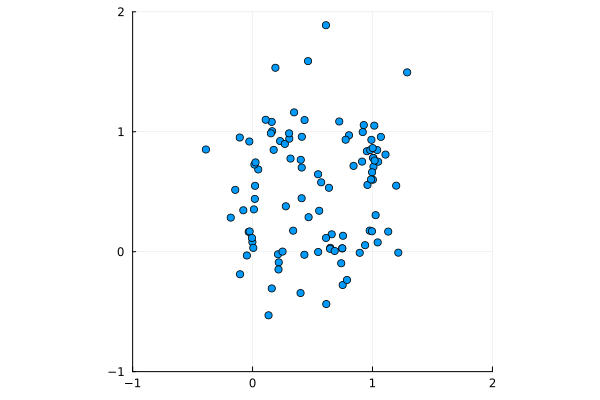

In [5]:
desired_digit = 0  # Change this to see others!
desired_noise = 0.5
constraints = Gen.choicemap()
constraints[:number] = desired_digit
constraints[:p_noise] = desired_noise
trace, _ = Gen.generate(number_model, (), constraints)

obs = Gen.get_retval(trace)

xs = obs[:, 1]
ys = obs[:, 2]

Plots.scatter(xs, ys, legend=false, xlim=(-1, 2), ylim=(-1.0, 2.0), aspect_ratio=:equal)



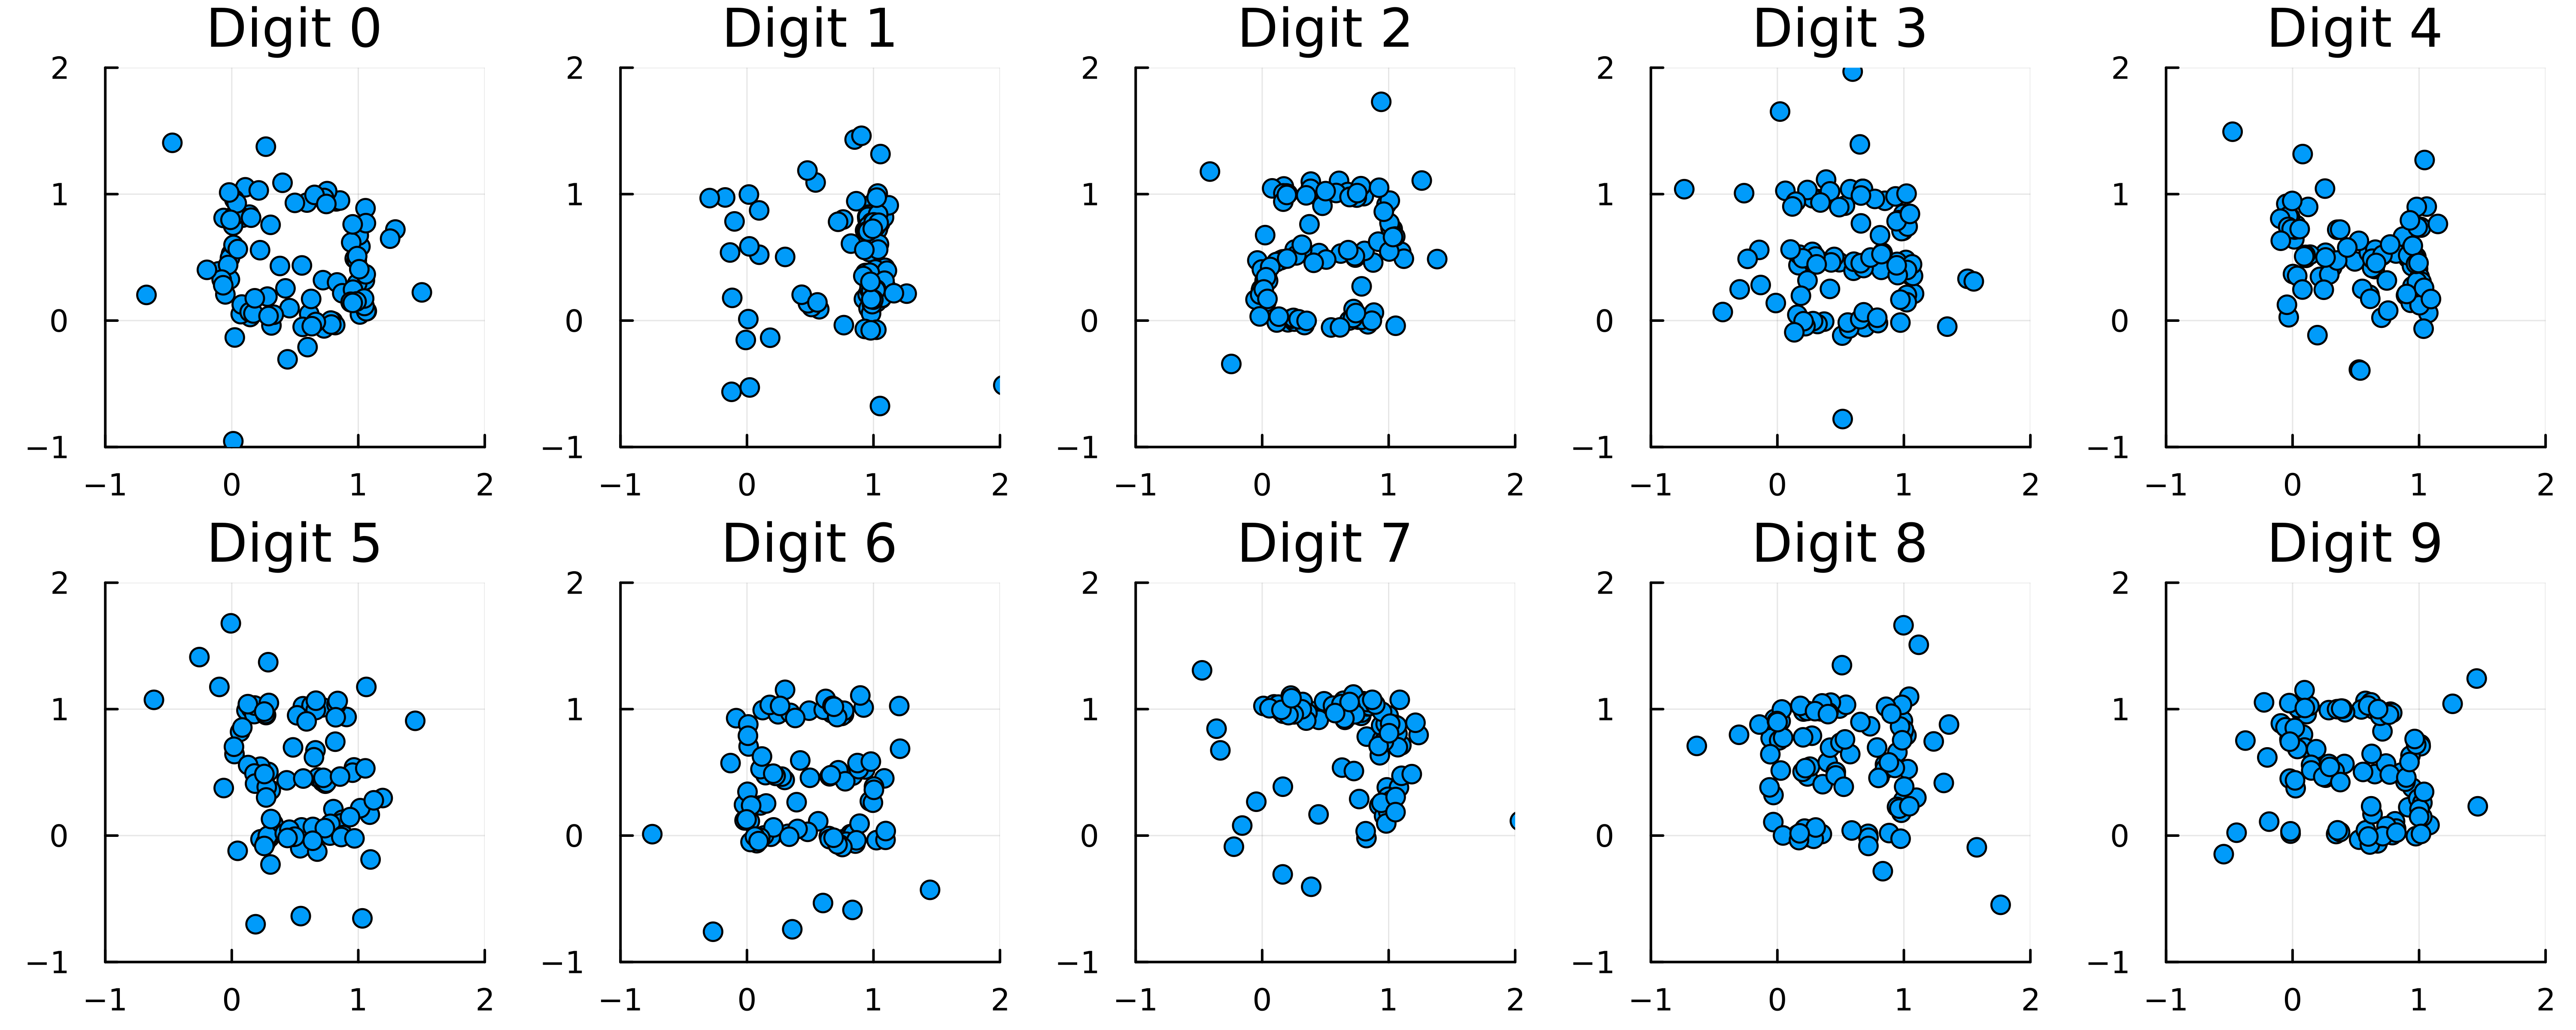

In [6]:
# Plot all the samples
plots = []

for digit in 0:9
    constraints = Gen.choicemap()
    constraints[:number] = digit
    constraints[:p_noise] = 0.3
    trace, _ = Gen.generate(number_model, (), constraints)
    obs = Gen.get_retval(trace)



    xs = obs[:, 1]
    ys = obs[:, 2]
    p = Plots.scatter(xs, ys, legend=false, xlim=(-1, 2), ylim=(-1.0, 2.0), aspect_ratio=:equal, title="Digit $(digit)")
    push!(plots, p)
end
p = plot(plots..., layout=(2, 5), size=(1000, 400), dpi=600)
# savefig(p, "digits.png")

# Define inference method

We can use importance sampling to infer the digit from a sample.  Here, we try
to find the digit that maximizes the likelihood of the sample.

In [7]:
function do_inference(model, obs, n_iters)
    choice_obs = Gen.choicemap()
    for i in 1:size(obs, 1)
        choice_obs[(:obs) => (:p, i)] = obs[i, :]
    end
    (trace, lml_est) = Gen.importance_resampling(model, (), choice_obs, n_iters)
    return trace, lml_est
end

do_inference (generic function with 1 method)

# Do Inference
We can sample a noisy digit and then infer the digit from the sample.

Inferred number: 9
lml_est: -74.54917439488993
Inferred noise: 0.2325070996852581


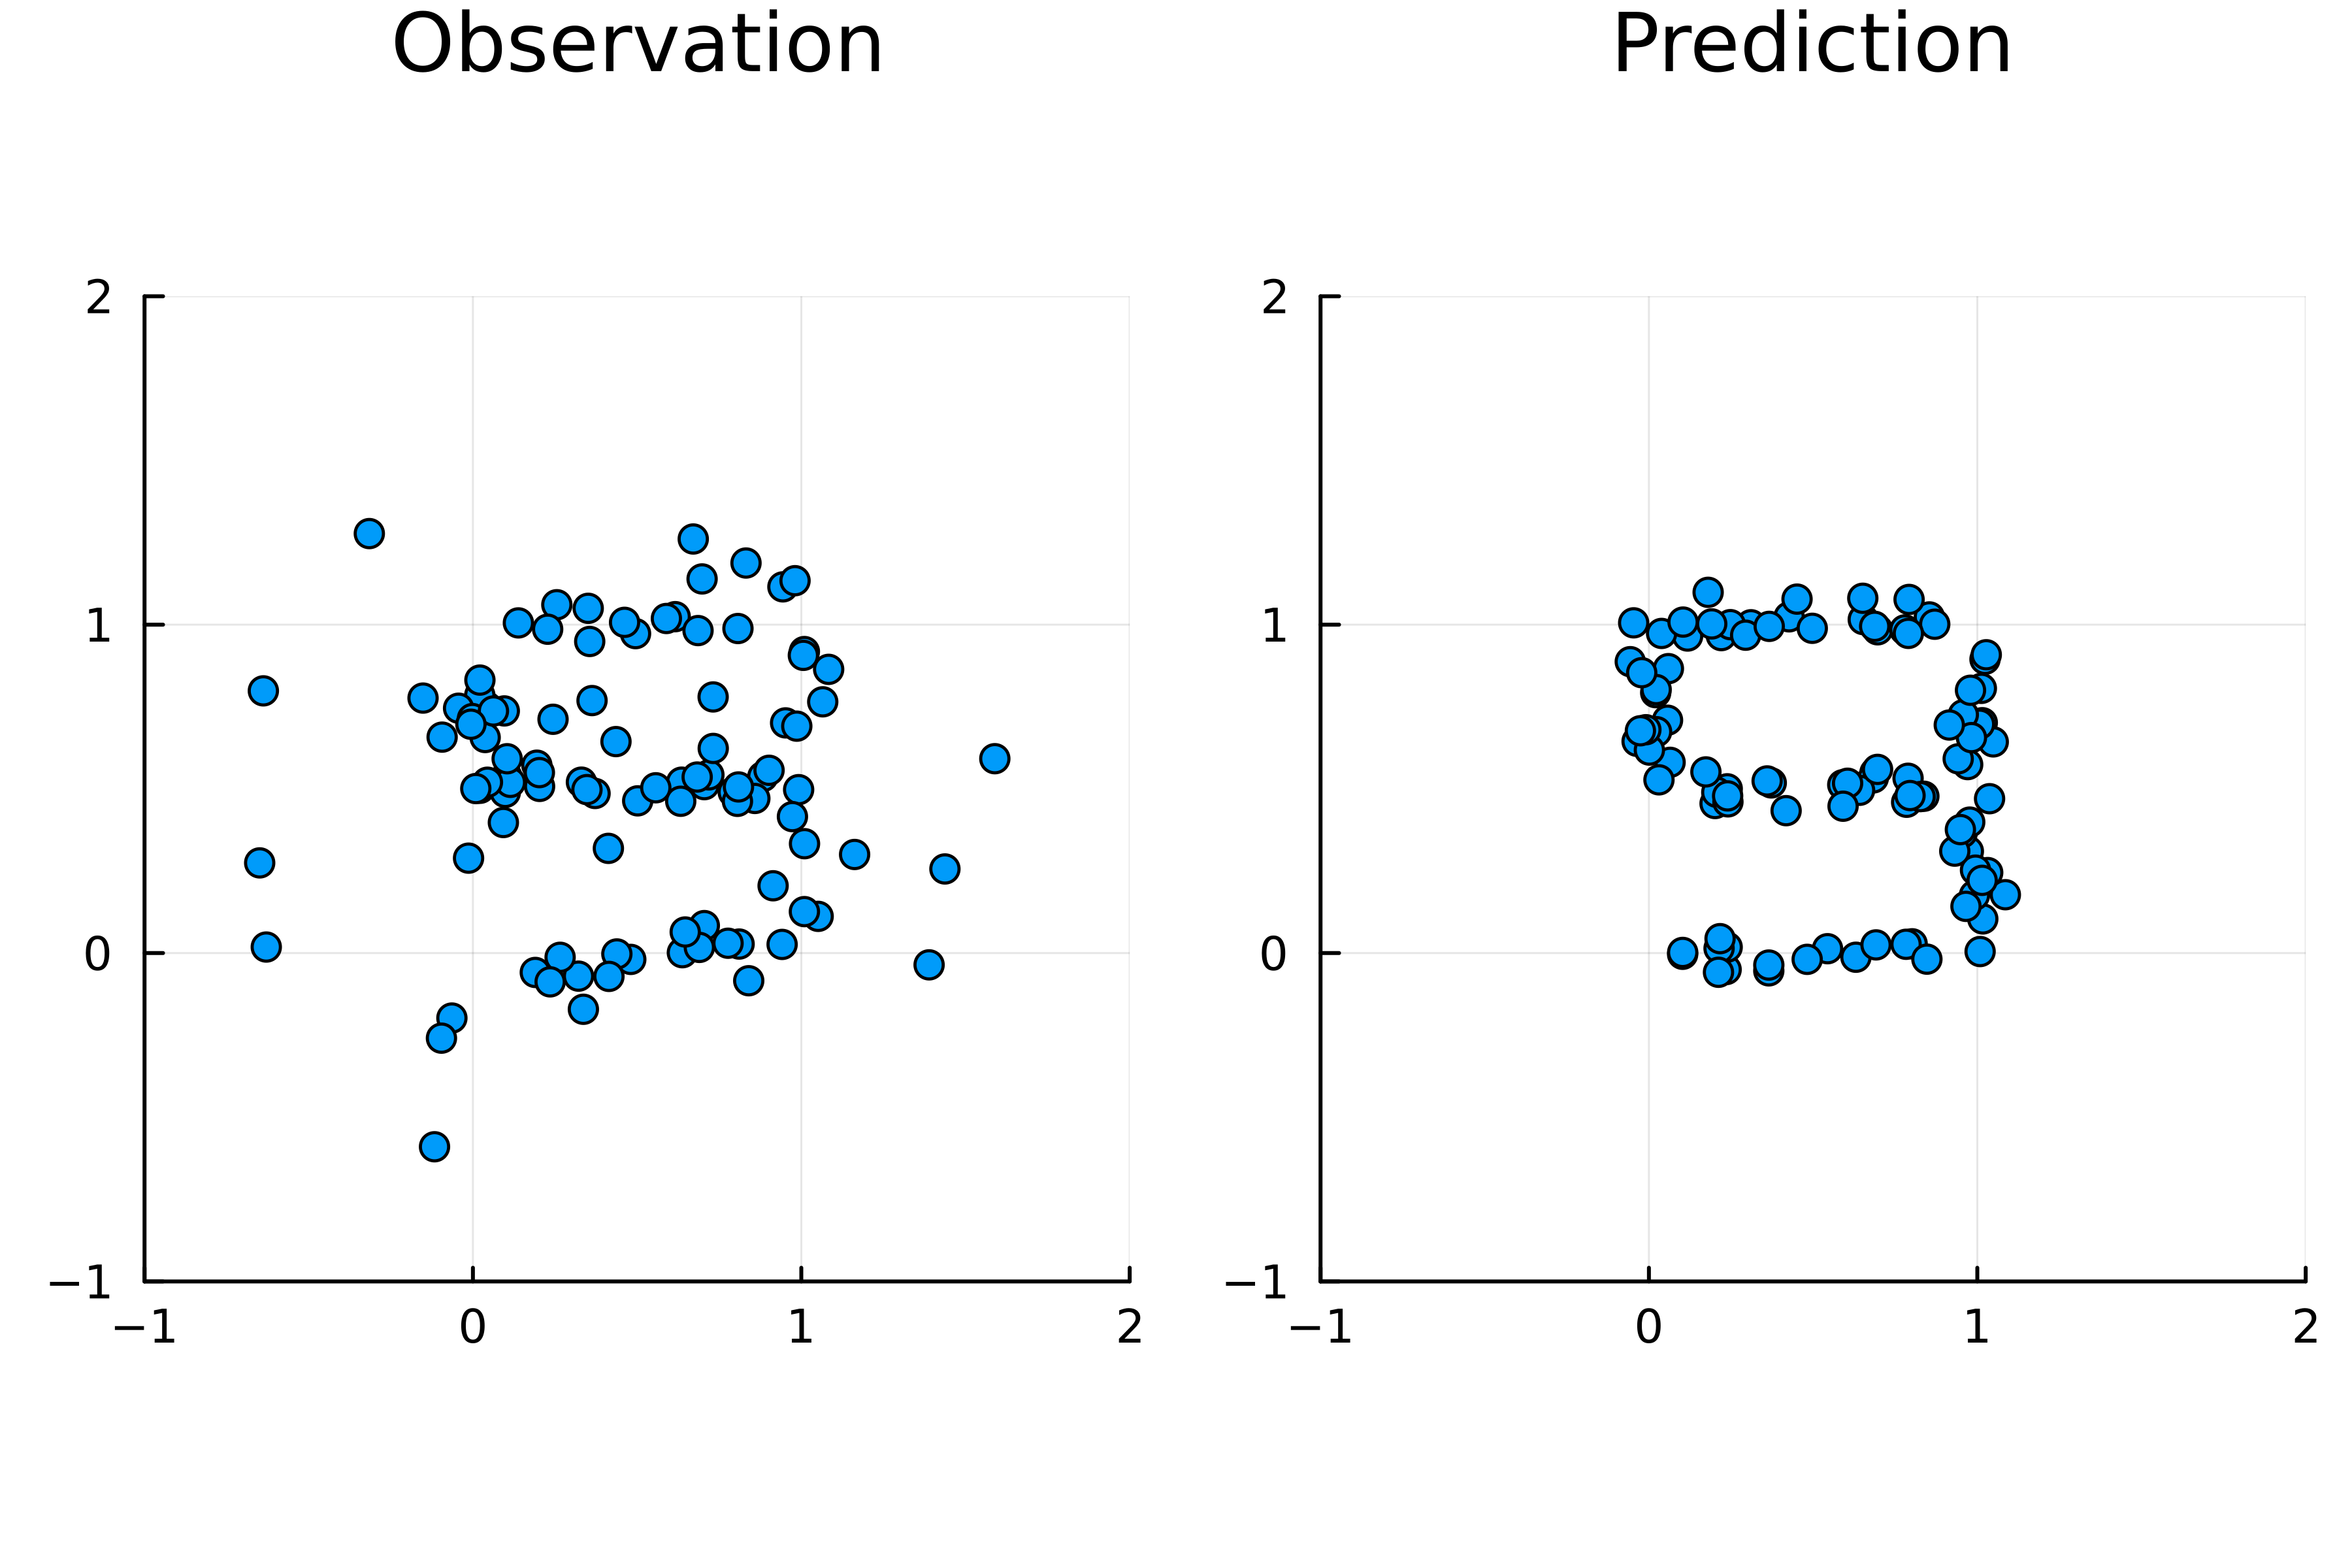

In [8]:
ground_truth_number = 9  # Set this to try different numbers!
ground_truth_noise = 0.3
constraints = Gen.choicemap()
constraints[(:number)] = ground_truth_number
constraints[(:p_noise)] = ground_truth_noise
trace, _ = Gen.generate(number_model, (), constraints)
obs = Gen.get_retval(trace)

trace, lml_est = do_inference(number_model, obs, 1000)
inferred_number = trace[(:number)]
# println("Inferred number: ", inferred_number)

println("Inferred number: ", inferred_number)
println("lml_est: ", lml_est)
println("Inferred noise: ", trace[(:p_noise)])

pred_choicemap = Gen.choicemap()
pred_choicemap[:number] = inferred_number
pred_choicemap[:p_noise] = 0.0
pred_trace, _ = Gen.generate(number_model, (), pred_choicemap)
# pred_trace, _ = Gen.generate(number_model, (), constraints)
pred_no_noise = Gen.get_retval(pred_trace)

observations = Plots.scatter(obs[:, 1], obs[:, 2], legend=false, xlim=(-1, 2), ylim=(-1.0, 2.0), aspect_ratio=:equal, title="Observation")
prediction = Plots.scatter(pred_no_noise[:, 1], pred_no_noise[:, 2], legend=false, xlim=(-1, 2), ylim=(-1.0, 2.0), aspect_ratio=:equal, title="Prediction")

plot(observations, prediction, dpi=600)
# savefig("prediction.png")


We can run inference on all digits

Inferred number: 0
lml_est: -40.38564431241719
Inferred noise: 0.1477009413564179
Inferred number: 

1
lml_est: 64.36828594284553
Inferred noise: 0.2574895370664958


Inferred number: 2
lml_est: -50.67476365570677
Inferred noise: 0.2131371000814429
Inferred number: 

3
lml_est: -38.14217395429906
Inferred noise: 0.25498471901592284


Inferred number: 4
lml_est: -28.997551526467287
Inferred noise: 0.29815452271919823
Inferred number: 

5
lml_est: -42.22495148658014
Inferred noise: 0.2562950287224746


Inferred number: 6
lml_est: -75.13882914675963
Inferred noise: 0.27898293717992295
Inferred number: 

7
lml_est: -3.7837133453688927
Inferred noise: 0.21968132056447606


Inferred number: 8
lml_est: -17.024437470511725
Inferred noise: 0.19487316451913894
Inferred number: 

9
lml_est: -53.9614627327479
Inferred noise: 0.275373133285944


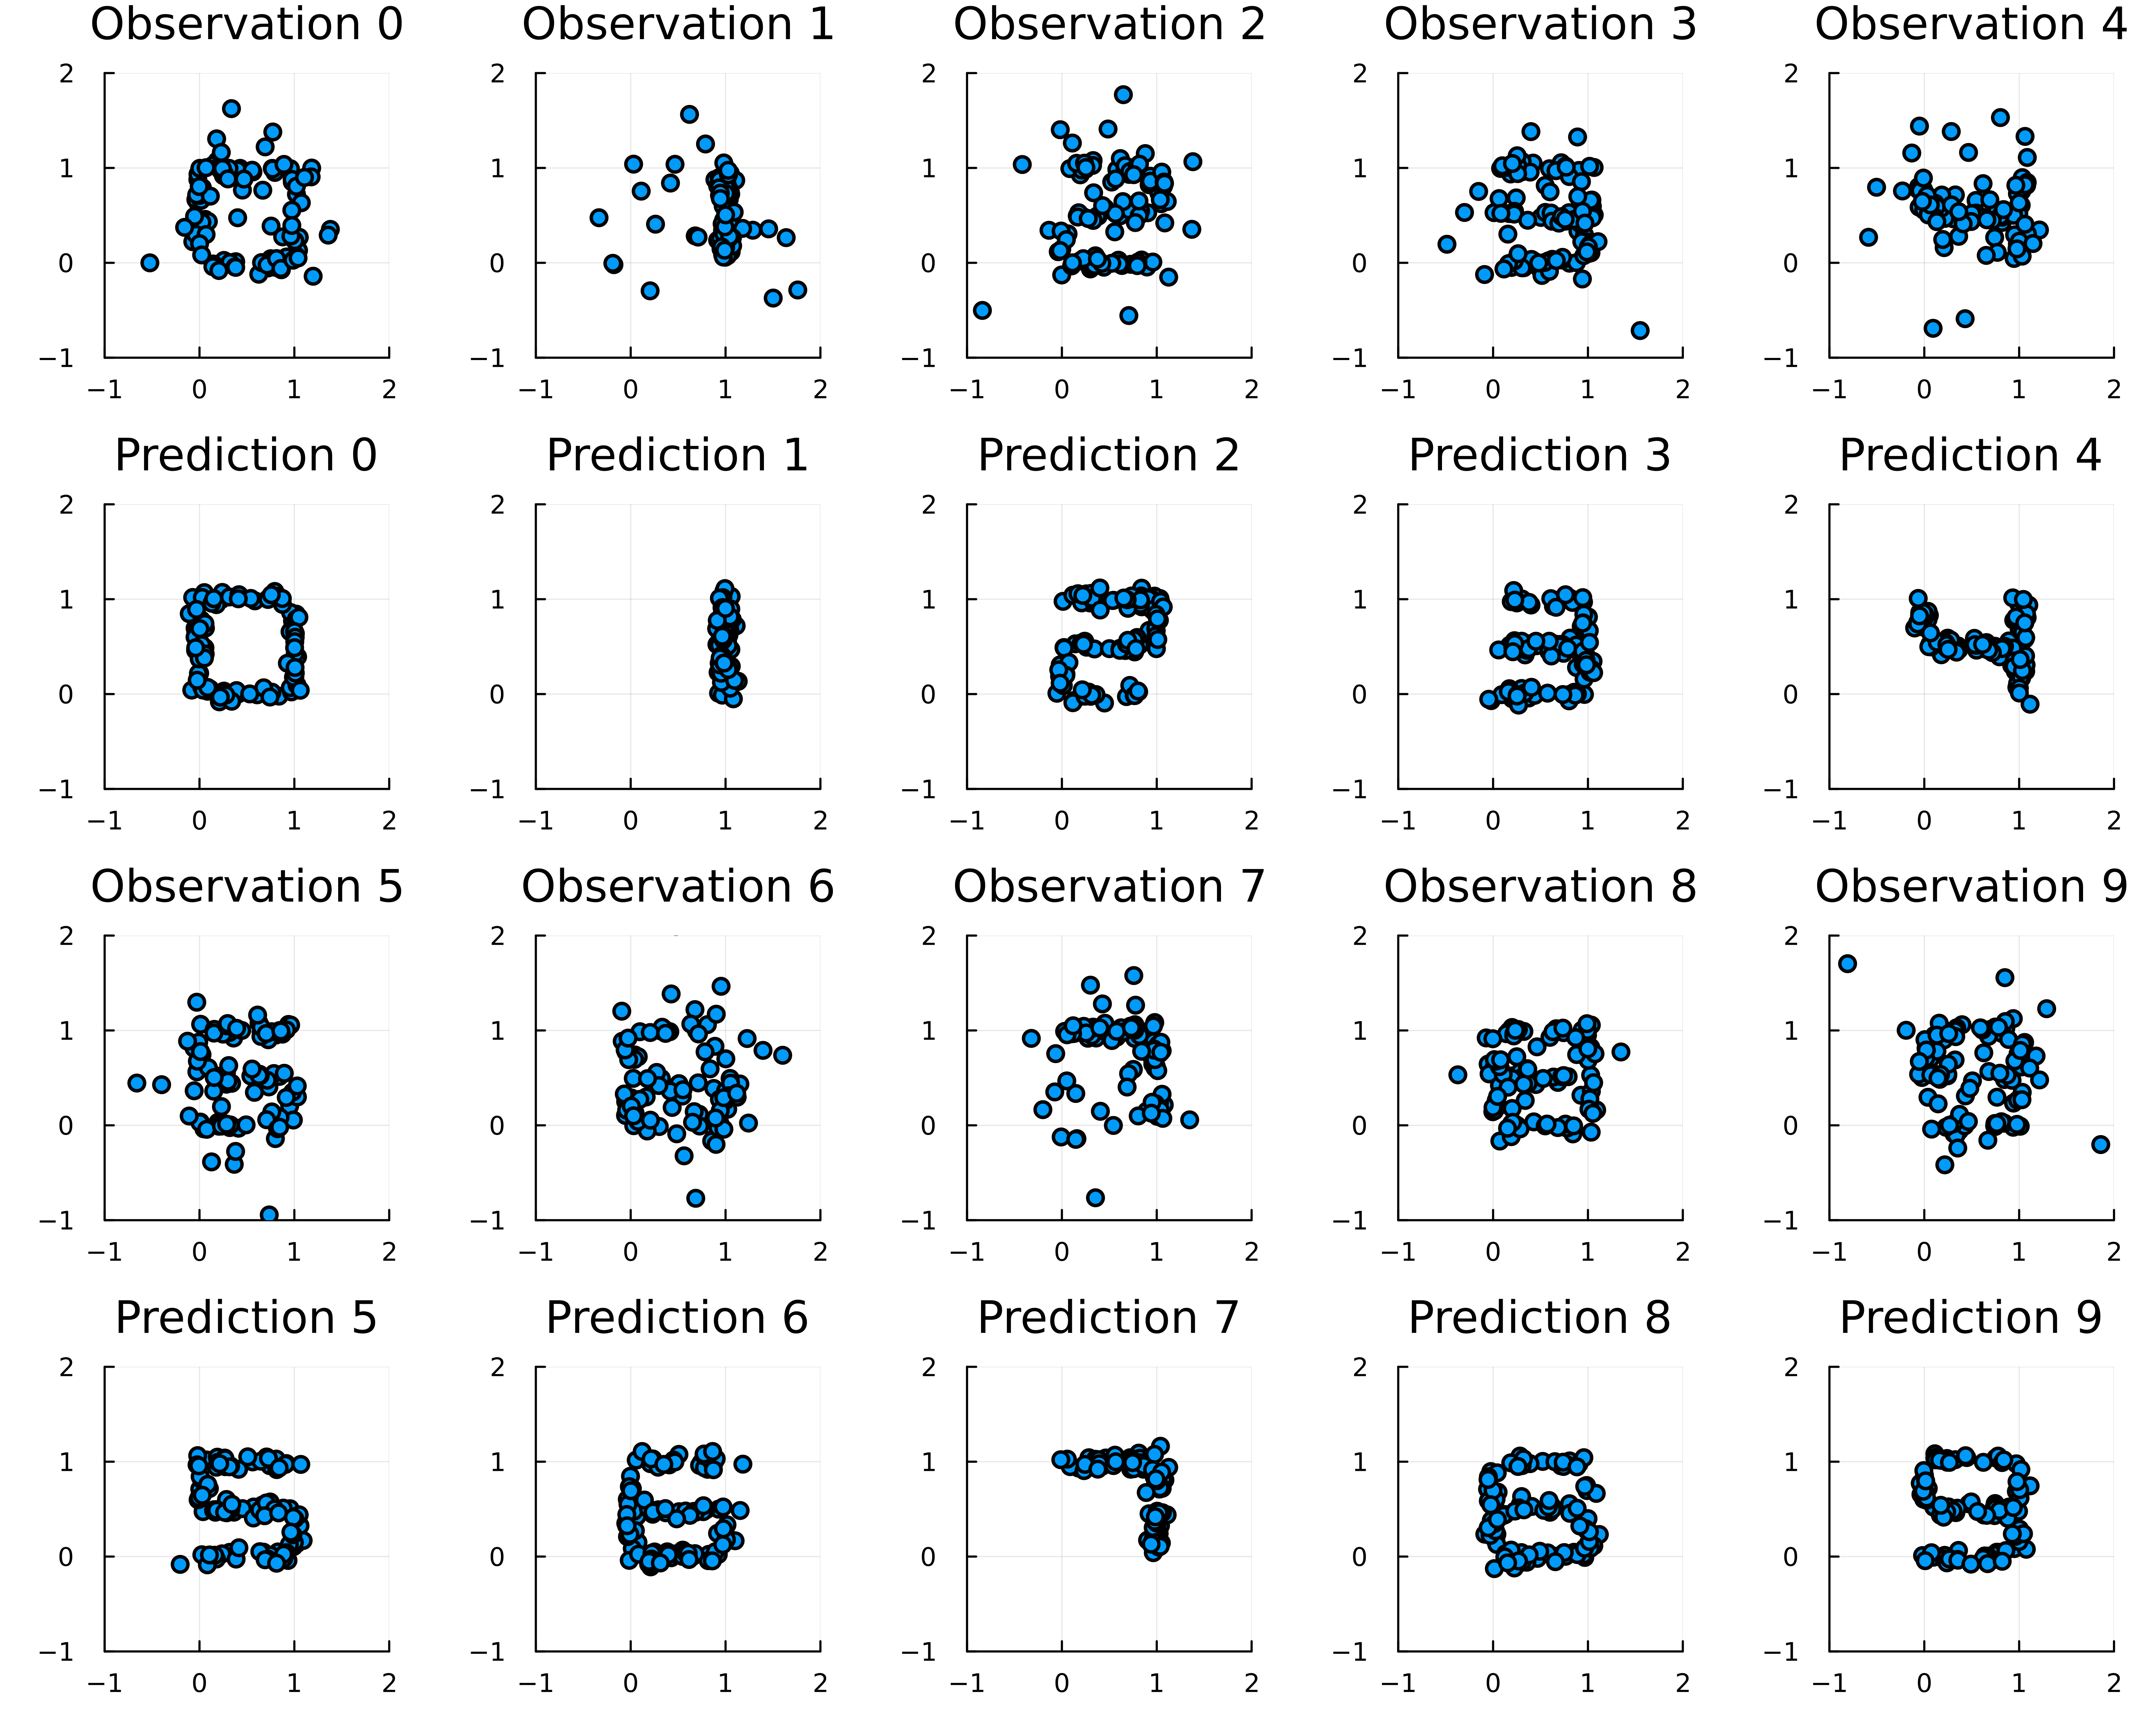

In [9]:
# Plot all the samples
obs_plots = []
pred_plots = []

for digit in 0:9
    constraints = Gen.choicemap()
    constraints[:number] = digit
    constraints[:p_noise] = 0.3
    trace, _ = Gen.generate(number_model, (), constraints)
    obs = Gen.get_retval(trace)

    trace, lml_est = do_inference(number_model, obs, 1000)
    inferred_number = trace[(:number)]
    # println("Inferred number: ", inferred_number)

    println("Inferred number: ", inferred_number)
    println("lml_est: ", lml_est)
    println("Inferred noise: ", trace[(:p_noise)])

    pred_choicemap = Gen.choicemap()
    pred_choicemap[:number] = inferred_number
    pred_choicemap[:p_noise] = 0.0
    pred_trace, _ = Gen.generate(number_model, (), pred_choicemap)
    # pred_trace, _ = Gen.generate(number_model, (), constraints)
    pred_no_noise = Gen.get_retval(pred_trace)

    observations = Plots.scatter(obs[:, 1], obs[:, 2], legend=false, xlim=(-1, 2), ylim=(-1.0, 2.0), aspect_ratio=:equal, title="Observation $(digit)")
    prediction = Plots.scatter(pred_no_noise[:, 1], pred_no_noise[:, 2], legend=false, xlim=(-1, 2), ylim=(-1.0, 2.0), aspect_ratio=:equal, title="Prediction $(digit)")

    # plot(observations, prediction, dpi=600)
    push!(obs_plots, plot(observations, dpi=600))
    push!(pred_plots, plot(prediction, dpi=600))
    # savefig("prediction.png")

end
plot_arr = vcat(obs_plots[1:5], pred_plots[1:5], obs_plots[6:10], pred_plots[6:10])
p = plot(plot_arr..., layout=(4, 5), size=(1000, 800), dpi=600)

Finally, we can collect summary statistics on the inference results.

In [208]:
# Find average lmls for each digit
lmls = [0.0 for i in 1:10]
num_correct = [0 for i in 1:10]

n_trials = 50
for trial in 1:n_trials
    println("Trial: ", trial)
    for digit in 0:9
        constraints = Gen.choicemap()
        constraints[:number] = digit
        constraints[:p_noise] = 0.3
        trace, _ = Gen.generate(number_model, (), constraints)
        obs = Gen.get_retval(trace)

        trace, lml_est = do_inference(number_model, obs, 1000)
        inferred_number = trace[(:number)]
        # println("Inferred number: ", inferred_number)
        lmls[digit + 1] += lml_est
        if inferred_number == digit
            num_correct[digit + 1] += 1
        end
    end
end

print("Average lmls: ", lmls ./ n_trials)
print("Average success rate: ", num_correct ./ n_trials)

Trial: 1
Trial: 

2


Trial: 3
Trial: 

4


Trial: 5
Trial: 

6


Trial: 7
Trial: 

8


Trial: 9
Trial: 

10


Trial: 11
Trial: 

12


Trial: 13
Trial: 

14


Trial: 15
Trial: 

16


Trial: 17
Trial: 

18


Trial: 19
Trial: 

20


Trial: 21
Trial: 

22


Trial: 23
Trial: 

24


Trial: 25
Trial: 

26


Trial: 27
Trial: 

28


Trial: 29
Trial: 

30


Trial: 31
Trial: 

32


Trial: 33
Trial: 

34


Trial: 35
Trial: 

36


Trial: 37
Trial: 

38


Trial: 39
Trial: 

40


Trial: 41
Trial: 

42


Trial: 43
Trial: 

44


Trial: 45
Trial: 

46


Trial: 47
Trial: 

48


Trial: 49
Trial: 

50


Average lmls: [-53.972177630463804, 19.872986388424607, -50.3313558226432, -47.71791150196279, -25.41555009816492, -53.984695162922804, -58.59577994670468, -20.93958316848162, -65.96096270664631, -60.58046336447154]Average success rate: [1.0, 1.0, 1.0, 0.94, 1.0, 0.92, 0.92, 1.0, 0.86, 0.86]